In [1]:
from deap import base
from deap import creator
from deap import tools
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
POP_SIZE = 200
MAX_GENS = 200

MIN_INIT = 0
MAX_INIT = 800

MIN_PVEL = -24
MAX_PVEL =  24

MAX_LUPF = MAX_GUPF = 2.0

In [3]:
# supplier statistics (cost per component manufactured)
suppStats = {'rmCost': [60, 65, 55, 70, 60], # raw material cost
             'cmCost': [35, 40, 35, 40, 30], # component manufacturing cost
             'cmCap': [700, 700, 500, 700, 550]}  # component manufacturing capacity

# manufacturer statistics (cost per product manufactured)
manuStats = {'csCost': [70, 75, 65, 80, 70], # component sourcing cost
             'pmCost': [15, 20, 15, 15, 20], # product manufacturing cost
             'csCap': [500, 600, 400, 550, 600], # component storage capacity
             'pmCap': [550, 600, 450, 550, 600], # product manufacturing capacity
             'smCost': [20, 25, 15, 15, 20]} # supplier-manufacturer transportation cost

# distributor statistics (cost per product shipped)
distStats = {'wsCost': [20, 25, 15, 20, 20], # warehouse storage cost
             'wsCap': [700, 900, 500, 600, 350], # warehouse storage capacity
             'mdCost': [10, 15, 15, 20, 10]} # manufacturer-distributor transportation cost

# retailer statistics (cost per product sold)
retaStats = {'psCost': [110, 105, 110, 115, 120], # product sourcing cost
             'psCap': [600, 500, 800, 500, 600],  # product storage capacity
             'demand': [550, 500, 750, 500, 600], # nominal product demand
             'drCost': [15, 20, 25, 15, 20]} # distributor-retailer transportation cost
                     
        
def _addUncertainties(demands):
    """
    Introduction of uncertainty in the demand in the form of random changes in percentage difference ranging between -25% and +25%

    Input  - demand (int)
    Output - demand (int)
    """
    percent    = [-0.25, -0.1, 0, 0.1, 0.25]
    newDemands = demands * (1+np.random.choice(percent, 5))
    return newDemands.astype(int)


def _totalPenalty(solution):
    """
    Total penalty from violations of constraints throughout the supply chain network
    
    Input  - solution (array)
    Output - score (int)
    """
    TP = 0   
    
    TP += np.clip(np.subtract(retaStats['psCap'], solution[0].sum(axis=0)), 0, None).sum() * 50
    TP += np.clip(np.subtract(distStats['wsCap'], solution[1].sum(axis=0)), 0, None).sum() * 50
    TP += np.clip(np.subtract(manuStats['csCap'], solution[2].sum(axis=0)), 0, None).sum() * 50
    
    TP += np.clip(np.subtract(manuStats['pmCap'], solution[1].sum(axis=1)), 0, None).sum() * 100
    TP += np.clip(np.subtract(suppStats['cmCap'], solution[2].sum(axis=1)), 0, None).sum() * 100
    
    TP += np.clip(np.subtract(_addUncertainties(retaStats['demand']), solution[0].sum(axis=0)), 0, None).sum() * 250
    return TP


def _totalCost(solution):
    """
    Total costs incurred throughout the supply chain network.

    Input  - solution (array)
    Output - score (int)
    """
    TC = 0
    TC += np.multiply(solution[0].sum(axis=0), np.add(retaStats['psCost'], retaStats['drCost'])).sum() # total retailer cost
    TC += np.multiply(solution[0].sum(axis=1), np.add(distStats['wsCost'], distStats['mdCost'])).sum() # total distributor cost
    TC += np.multiply(solution[1].sum(axis=1), np.add(np.add(manuStats['csCost'], manuStats['pmCost']), manuStats['smCost'])).sum() # total manufacturer cost
    TC += np.multiply(solution[2].sum(axis=1), np.add(suppStats['rmCost'], suppStats['cmCost'])).sum() # total supplier cost    
    return TC


def _fitness(solution):
    """
    Fitness is defined as the sum of total costs and total penalties arising from violation of constraints.
    
    Input  - solution (array)
    Output - score (int)
    """
    fit = _totalCost(solution) + _totalPenalty(solution)
    return fit,

In [4]:
def _createParticle():
    particle = creator.Particle(np.random.randint(MIN_INIT, MAX_INIT, (3,5,5)))
    particle.speed = np.random.randint(MIN_PVEL, MAX_PVEL, (3,5,5))
    return particle

def _updateParticle(particle, best):
    localUF = np.random.uniform(0, MAX_LUPF, (3,5,5))
    globalUF = np.random.uniform(0, MAX_GUPF, (3,5,5))

    localSU = localUF   * (particle.best - particle)
    globalSU = globalUF * (best - particle)

    particle.speed = particle.speed + (localSU + globalSU)
    particle.speed = np.clip(particle.speed, MIN_PVEL, MAX_PVEL)
    particle[:] = particle + particle.speed
    particle[:] = np.clip(particle, 0, None)

In [5]:
toolbox = base.Toolbox()

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Particle", np.ndarray, fitness=creator.FitnessMin, speed=None, best=None)

toolbox.register("particleCreator", _createParticle)
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.particleCreator)
toolbox.register("evaluate", _fitness)

toolbox.register("update", _updateParticle)

In [6]:
def main():
    
    np.random.seed(28)
    population = toolbox.populationCreator(n=POP_SIZE)

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("avg", np.mean)

    logbook = tools.Logbook()
    logbook.header = ["gen", "evals"] + stats.fields

    best = None

    for generation in tqdm(range(MAX_GENS)):
        for particle in population:
            particle.fitness.values = toolbox.evaluate(particle)

            if particle.best is None or particle.best.size==0 or particle.best.fitness < particle.fitness:
                particle.best = creator.Particle(particle)
                particle.best.fitness.values = particle.fitness.values

            if best is None or best.size==0 or best.fitness<particle.fitness:
                best = creator.Particle(particle)
                best.fitness.values = particle.fitness.values

        for particle in population:
            toolbox.update(particle, best)

        logbook.record(gen=generation, evals=len(population), **stats.compile(population))
        #print(logbook.stream)
        
    return population, logbook, best
        
if __name__ == "__main__":
    population, logbook, best = main()

In [8]:
Gen = logbook.select("gen")
Min = logbook.select("min")
Avg = logbook.select("avg")

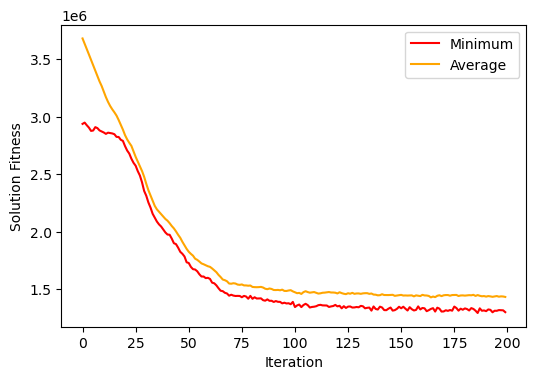

In [9]:
plt.figure(figsize=(6,4), dpi=100);
plt.plot(Gen, Min, color="red", label="Minimum");
plt.plot(Gen, Avg, color="orange", label="Average");
plt.ylabel("Solution Fitness")
plt.xlabel("Iteration")
plt.legend();